In [1]:
# uncomment and run this if you are on colab
# !pip install pyballmapper

In [2]:
import numpy as np
import pandas as pd
import networkx as nx

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [3]:
from IPython.display import clear_output

## Generate data

In [22]:
from sklearn import datasets

n_samples = 1000
X, y = datasets.make_circles(
    n_samples=n_samples, factor=0.3, noise=0.05, random_state=42
)
print(X.shape)

(1000, 2)


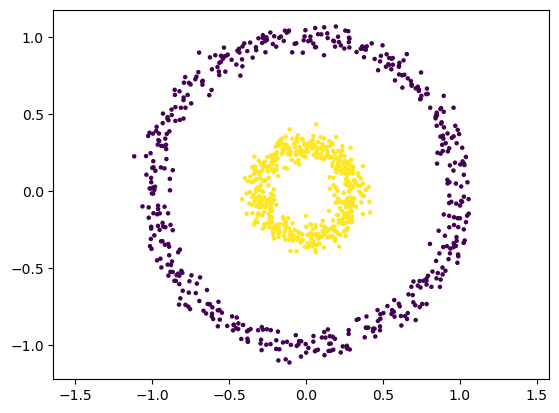

In [23]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=5)
plt.axis("equal")
plt.show()

## Create BallMapper graph

In [24]:
from pyballmapper import BallMapper

In [25]:
bm = BallMapper(
    points=X,  # the pointcloud, as a numpy array
    epsilon=0.25,  # the radius of the balls
    dbg=False,
)

In [26]:
# bm.Graph is a networkx graph

# we use the cluster id as coloring functions
bm.add_coloring(coloring_df=pd.DataFrame(y, columns=["y"]))
clear_output()  # newer versions of pandas produce a lot of warings when I launch the above function :)

# here we adopt a standard colour palette
from matplotlib import cm

my_palette = cm.get_cmap(name="viridis")

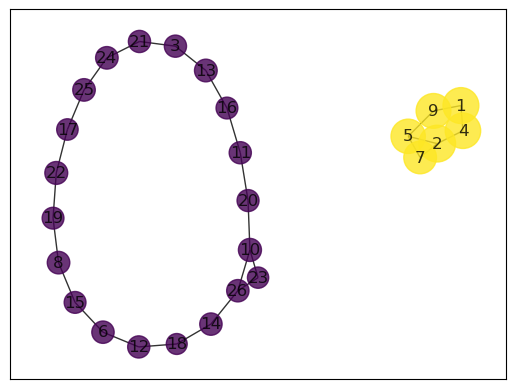

In [27]:
plt.figure()
# The BallMapper class has a builtin plotting method, buit around nx.draw_networkx
bm.draw_networx(coloring_variable="y", color_palette=my_palette)
plt.show()

## BM with reverse ordering

In [28]:
# we can change the order of the points
# this will affect the landmarks selection
# for example, lets use the reverse ordering
bm_reverse = BallMapper(
    points=X,  # the pointcloud, as a numpy array
    epsilon=0.25,  # the radius of the balls
    order=list(reversed(range(len(X)))),  # reverse ordering
)

In [29]:
bm_reverse.add_coloring(coloring_df=pd.DataFrame(y, columns=["y"]))
clear_output()  # newer versions of pandas produce a lot of warings when I launch the above function :)

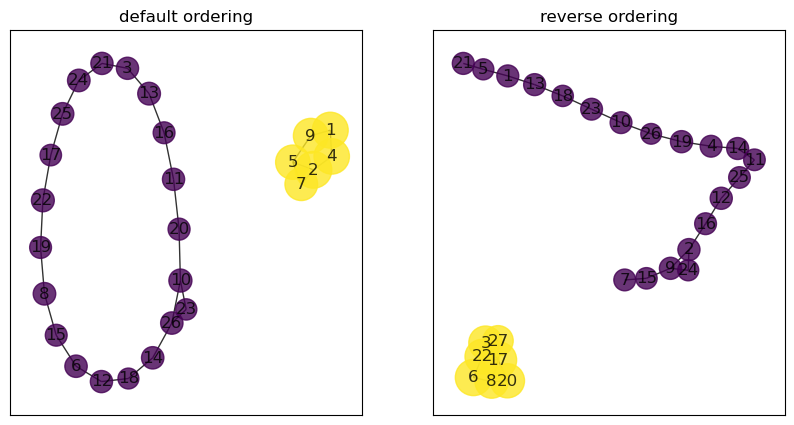

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

bm.draw_networx(coloring_variable="y", color_palette=my_palette, this_ax=axs[0])
bm_reverse.draw_networx(coloring_variable="y", color_palette=my_palette, this_ax=axs[1])

axs[0].set_title("default ordering")
axs[1].set_title("reverse ordering")

plt.show()

# why is this happening???

let us take a closer look at balls 21 and 7...

they really do not have any points in common!

if you do not believe it, the figure below is saved in `high_def.pdf`, try zooming in

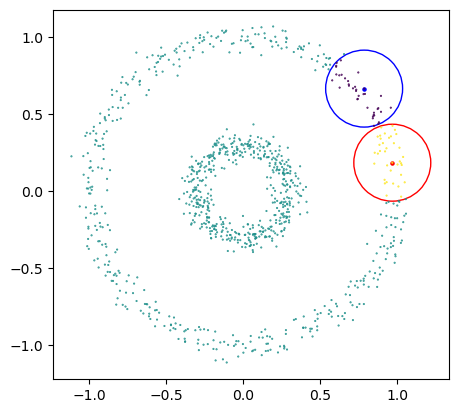

In [31]:
color = [0 for i in range(len(X))]
for i in range(len(X)):
    if i in bm_reverse.points_covered_by_landmarks[7]:
        color[i] = 1
    elif i in bm_reverse.points_covered_by_landmarks[21]:
        color[i] = -1

fig, ax = plt.subplots()

ax.set_aspect("equal")

lndmk1 = X[bm_reverse.Graph.nodes[7]["landmark"]]
ax.scatter(lndmk1[0], lndmk1[1], s=5, c="r")
cir1 = plt.Circle((lndmk1[0], lndmk1[1]), 0.25, color="r", fill=False)

lndmk2 = X[bm_reverse.Graph.nodes[21]["landmark"]]
ax.scatter(lndmk2[0], lndmk2[1], s=5, c="b")
cir2 = plt.Circle((lndmk2[0], lndmk2[1]), 0.25, color="b", fill=False)
ax.add_patch(cir1)
ax.add_patch(cir2)


ax.scatter(X[:, 0], X[:, 1], c=color, cmap="viridis", s=0.25)

plt.savefig("high_def.pdf")
plt.show()

## Shuffle points

Permute the input point cloud to obtain different collections of landmars and different graphs.

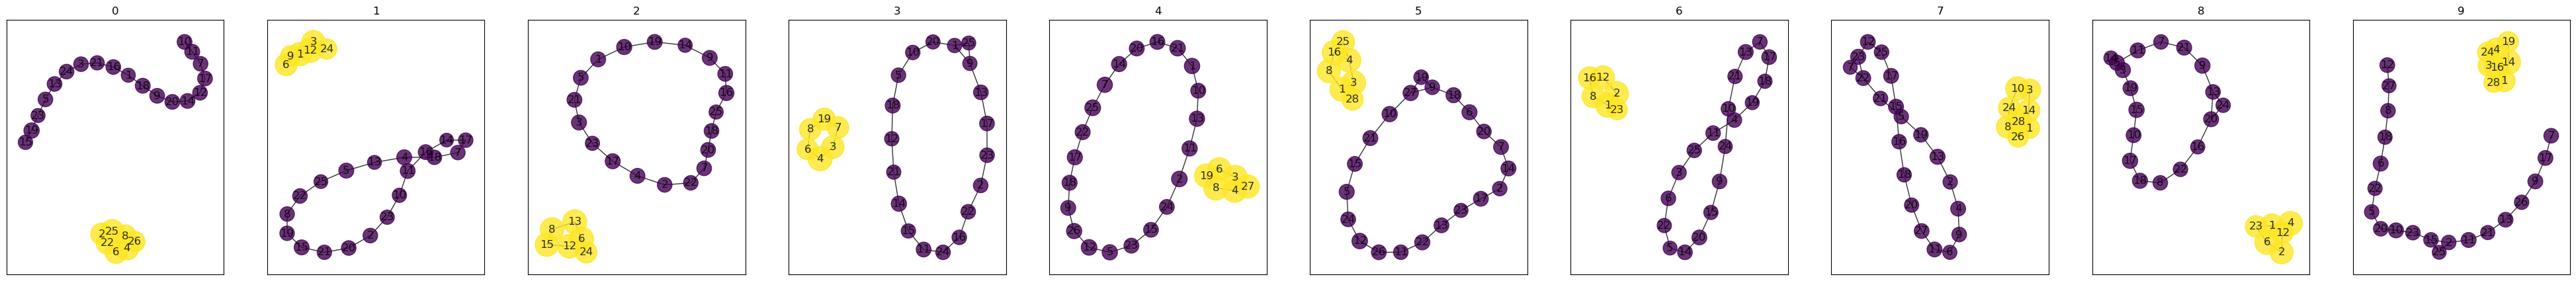

In [41]:
rng = np.random.default_rng(seed=66)

num_it = 10

fig, axs = plt.subplots(1, num_it, figsize=(5 * num_it, 5))

for i in range(num_it):

    shuffle = rng.permutation(range(len(X))).tolist()

    bm_shuffled = BallMapper(
        points=X,  # the pointcloud, as a numpy array
        epsilon=0.25,  # the radius of the balls
        order=shuffle,
    )  # shuffled ordering

    bm_shuffled.add_coloring(coloring_df=pd.DataFrame(y, columns=["y"]))
    clear_output()

    bm_shuffled.draw_networx(
        coloring_variable="y", color_palette=my_palette, this_ax=axs[i]
    )
    axs[i].set_title(i)

plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Connected components on various radii

A functionality that iterate through various radii, find connected components of the BM graph, and write down the points that are covered by those connected component.

In [42]:
## we will save the points in a nested dict
## for each radius we save the points in the various connected components

# { ...,
#
# radius :
#     {
#         cc_0 : [points covered by cc_0],
#         cc_1 : [points covered by cc_1],
#         ...
#     } ,
#  ....
#
# }

(1000, 2)


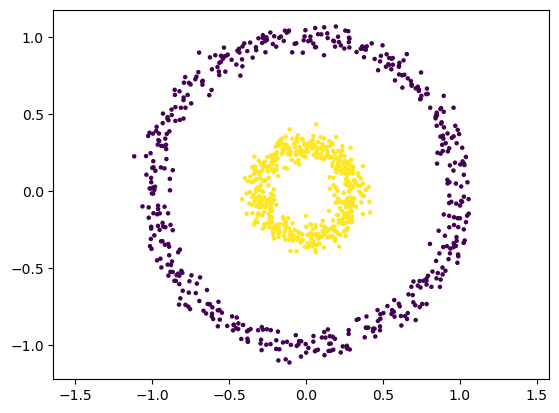

In [43]:
from sklearn import datasets

n_samples = 1000
X, y = datasets.make_circles(
    n_samples=n_samples, factor=0.3, noise=0.05, random_state=42
)
print(X.shape)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=5)
plt.axis("equal")
plt.show()

In [44]:
from pyballmapper import BallMapper

In [46]:
cc = [
    [1, 2],
    [
        2,
        3,
        4,
    ],
    [4, 5, 5],
]
list(set().union(*cc))

[1, 2, 3, 4, 5]

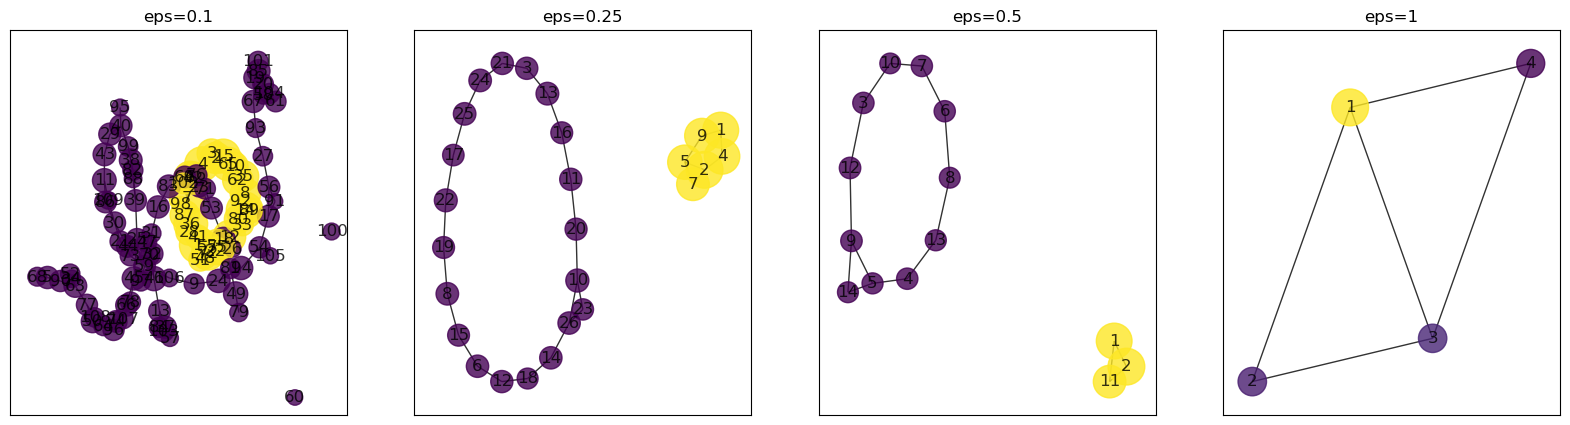

In [58]:
output = {}

radii_list = [0.1, 0.25, 0.5, 1]

fig, axs = plt.subplots(1, len(radii_list), figsize=(5 * len(radii_list), 5))

for ax_id, eps in enumerate(radii_list):

    cc_dict = {}

    bm = BallMapper(
        points=X, epsilon=eps  # the pointcloud, as a numpy array
    )  # the radius of the balls)

    # iterate through a sorted list of connected components, largest first.
    for i, cc in enumerate(
        sorted(nx.connected_components(bm.Graph), key=len, reverse=True)
    ):
        points_in_cc = list(
            set().union(*[bm.points_covered_by_landmarks[idx] for idx in cc])
        )
        cc_dict["cc_{}".format(i)] = points_in_cc

    output[eps] = cc_dict

    bm.add_coloring(coloring_df=pd.DataFrame(y, columns=["y"]))
    clear_output()
    bm.draw_networx(coloring_variable="y", color_palette=my_palette, this_ax=axs[ax_id])
    axs[ax_id].set_title("eps={}".format(eps))

In [59]:
for eps in output.keys():
    print(
        "with radius={} we have {} connected components".format(eps, len(output[eps]))
    )
    for cc in output[eps].keys():
        print("\t {} with size {}".format(cc, len(output[eps][cc])))
    print()

with radius=0.1 we have 5 connected components
	 cc_0 with size 346
	 cc_1 with size 500
	 cc_2 with size 148
	 cc_3 with size 2
	 cc_4 with size 4

with radius=0.25 we have 2 connected components
	 cc_0 with size 500
	 cc_1 with size 500

with radius=0.5 we have 2 connected components
	 cc_0 with size 500
	 cc_1 with size 500

with radius=1 we have 1 connected components
	 cc_0 with size 1000

